# New Section

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/openfoamDATA/all_data_vanKarman.hdf5' all_data.hdf5

In [ ]:
!cp '/content/drive/MyDrive/all_data_vanKarman_steps.hdf5' all_data.hdf5

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.models import Model
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.colors as colors

# lstm_1

In [ ]:

def lstm_model():
    inputs = tf.keras.Input(shape=(None, 50, 250, 3))

    c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'))(inputs)  # (None, 50, 150, 32)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c1)  # (None, 25, 75, 32)

    c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'))(x)  # (None, 25, 75, 64)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c2)  # (None, 13, 38, 64)

    c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))(x)  # (None, 13, 38, 128)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c3)  # (None, 7, 19, 128)

    x = tf.keras.layers.ConvLSTM2D(filters=256, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))(x)
    x = tf.keras.layers.Add()([x, c3])

    x = tf.keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))(x)
    x = tf.keras.layers.Add()([x, c2])

    x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.Add()([x, c1])

    x = tf.keras.layers.Conv3D(filters=3, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last')(x)

    model = Model(inputs=inputs, outputs=x)
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=False)
    print(model.summary())
    return model

# Read data

In [ ]:
def read_dataset(path=None, split=0.9, print_shape=False):
    times = 30
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:20, 0:times, ...]
    y = hdf5_file["sim_data"][:20, 1:(times+1), ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()


    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]


    def gen_locations(y_cells,y,x_cells,x):
      locations_x = np.zeros((y_cells,x_cells))
      locations_y = np.zeros((y_cells,x_cells))
      for i in range(y_cells):
        locations_y[i,:] = y/y_cells * i
      for j in range(x_cells):
        locations_x[:,j] = x/x_cells * j  
      return locations_x, locations_y

    locations_x, locations_y = gen_locations(50,1,250,5)  
    locations_x = locations_x.flatten()
    locations_y = locations_y.flatten()

    times_train = np.array([i for i in range(times)])
    times_test = np.array([i+1 for i in range(times)])

    N = locations_x.shape[0]
    T = times_train.shape[0]

    # Rearrange Data 
    XX = np.tile(locations_x, (1,T)).T # N x T
    YY = np.tile(locations_y, (1,T)).T # N x T
    TT = np.tile(times_train, (1,N)).T # N x T

    X = np.concatenate([XX,YY,TT],1)

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\nX.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape,
            X.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test, X

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test, _, _, X = read_dataset(hdf5_path, split=0.9, print_shape=True)



total_sim: 20
x_train.shape: (18, 30, 50, 250, 3)
y_train.shape: (18, 30, 50, 250, 3)
x_test.shape: (2, 30, 50, 250, 3)
y_test.shape: (2, 30, 50, 250, 3)
X.shape: (375000, 3)



# New Section

In [ ]:
import math
def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    data = hdf5_file["sim_data"][:, ...]

    def gen_locations(y_cells,y,x_cells,x):
      locations_x = np.zeros((y_cells,x_cells))
      locations_y = np.zeros((y_cells,x_cells))
      for i in range(y_cells):
        locations_y[i,:] = y/y_cells * i
      for j in range(x_cells):
        locations_x[:,j] = x/x_cells * j  
      return locations_x, locations_y
      
    locations_x, locations_y = gen_locations(data.shape[2],1,data.shape[3],5)  
  

    hdf5_file.close()

    times_train = [i for i in range(30)]
    times_test = [i+1 for i in range(30)]

    for j in range(data.shape[0]):
      for i in range(data.shape[1]-1):
        x.append(data[j, i, :,:]) 
        y.append(data[j, i+1,:,:])

    x = np.array(x)
    y = np.array(y)

    x_ = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2],6))
    y_ = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2],6))
    x__ = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2]))
    y__ = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2]))
    t__ = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2]))
    
    for i in range(x.shape[0]):
      x__[i,:,:] = locations_x
      y__[i,:,:] = locations_y
      t__[i,:,:] = np.ones((x.shape[1],x.shape[2])) * (i - math.floor(i/30)*30)

    x_[:,:,:,0] = x[:,:,:,0]
    x_[:,:,:,1] = x[:,:,:,1]
    x_[:,:,:,2] = x[:,:,:,2]
    x_[:,:,:,3] = x__
    x_[:,:,:,4] = y__
    x_[:,:,:,5] = t__
    x_ = np.array(x_)

    for j in range(y.shape[0]):
      t__[j,:,:] = np.ones((x.shape[1],x.shape[2])) * ((j+1) - math.floor((j+1)/30)*30)

    y_[:,:,:,0] = y[:,:,:,0]
    y_[:,:,:,1] = y[:,:,:,1]
    y_[:,:,:,2] = y[:,:,:,2]
    y_[:,:,:,3] = x__
    y_[:,:,:,4] = y__
    y_[:,:,:,5] = t__
    y_ = np.array(y_)
    
    
    total_sim = (x.shape[0])/30  #divide this way to make testing easier - x_test[0] will be the first time step of one sim

    x_train = x_[:(int(total_sim * split)*30), ...]
    y_train = y_[:(int(total_sim * split)*30), ...]
    x_test = x_[(int(total_sim * split)*30):int(total_sim)*30, ...]
    y_test = y_[(int(total_sim * split)*30):int(total_sim)*30, ...]
    #sim_no_train = sim_no[:int(total_sim * split), ...]
    #sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test




In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=False)

# LOSS

x_train : (n,50,150,5)

last collumn: 0-ux 1-uy 2-p 3-x 4-y

In [ ]:
#costum loss
def equations_loss(nu):
  def eqs_loss(y_true,y_pred):
    with tf.GradientTape(persistent=True) as tape:
      # Getting the prediction
      ux = y_pred[:,:,:,:,0].flatten()[:,None]
      uy = y_pred[:,:,:,:,1].flatten()[:,None]
      p = y_pred[:,:,:,:,2].flatten()[:,None]

      # Separating the collocation coordinates
      x = tf.convert_to_tensor(X[:, 0:1], dtype=self.dtype)
      y = tf.convert_to_tensor(X[:, 1:2], dtype=self.dtype)
      t = tf.convert_to_tensor(X[:, 2:3], dtype=self.dtype)


      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      ux_x = tape.gradient(ux, x)
      ux_y = tape.gradient(ux, y)
      
      uy_x = tape.gradient(uy, x)
      uy_y = tape.gradient(uy, y)


    # Getting the other derivatives
    ux_xx = tape.gradient(ux_x, x)
    ux_yy = tape.gradient(ux_y, y)

    uy_xx = tape.gradient(uy_x, x)
    uy_yy = tape.gradient(uy_y, y)

    ux_t = tape.gradient(ux, t)
    uy_t = tape.gradient(uy, t)
    p_x = tape.gradient(p, x)
    p_y = tape.gradient(p, y)
    
    residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
    residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)
    residual_continuity = ux_x + uy_y

    for i in range(ux.shape[0]):
      if (ux[i]== -1 and uy[i] == -1 and p[i] == -1):
        residual_NS_x[i] = 0
        residual_NS_y[i] = 0
        residual_continuity[i] = 0


    return tf.reduce_mean( tf.square(residual_continuity)) #+  tf.square(residual_NS_x) + tf.square(residual_NS_y) ) 


# train

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import h5py
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


hdf5_path = '/content/all_data.hdf5'
lr=1e-4
batch_size=10
epochs=1
x_train, y_train, x_test, y_test, _,_, X = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = lstm_model()
#model.add_loss(equations_loss(nu = 1.51e-4))

model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0, patience=10), TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]# PlotLearning()]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

score = model.evaluate(x=x_test, y=y_test, verbose=0)

print('Average Mean Squared Error:', score[0])

model.save('my_model3.h5')



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 50, 25 0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, None, 50, 250 416         input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_12 (TimeDistri (None, None, 25, 125 0           time_distributed_11[0][0]        
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, None, 25, 125 8256        time_distributed_12[0][0]        
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2/2 [==============================] - 165s 67s/step - loss: 1.2980 - MSE: 1.2980 - val_loss: 0.5927 - val_MSE: 0.5927
Average Mean Squared Error: 0.5927120447158813


In [ ]:

import os
import shutil
from keras.models import load_model
model = load_model('my_model.h5')

path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

#x_test, y_test = read_dataset()
sim = 1



#predicted_flow = predicted_flow.reshape(predicted_flow.shape[1:5])
#y_test = y_test.reshape(y_test.shape[1:5])

extent = 0, 3, 0, 1
predicted_flow =x_test[sim,:]
predicted_flow = predicted_flow.reshape(1,50,250,6)

plt.suptitle('Comparision of OpenFOAM vs Deep Learning: ux', fontsize=13)

plt.subplot(211)
plt.ylabel('OpenFOAM', fontsize=15)
plt.imshow(y_test[sim,:,:,0])
max_ux= np.max(y_test[sim,:,:,0]);
plt.clim(-1, max_ux);
plt.colorbar();


predicted_flow = model.predict(predicted_flow)

plt.subplot(212)
plt.ylabel('Deep Learning', fontsize=15)
plt.imshow(predicted_flow[0,:,:,0],)
plt.clim(-1, max_ux);
plt.colorbar();

  #plt.subplot(313)
  #plt.ylabel('ERRO Relativo', fontsize=15)
  #plt.imshow((y_test[20+i,:,:,2] - predicted_flow[0,:,:,2])/y_test[20+i,:,:,2])
  #plt.colorbar();



(100, 31, 50, 250, 3)
x_test.shape: (1, 2, 50, 250, 3)
y_test.shape: (1, 2, 50, 250, 3)



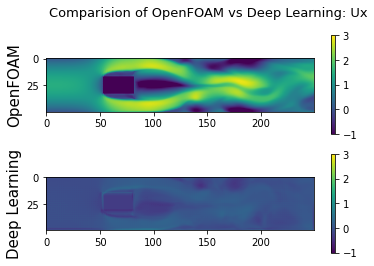

In [ ]:
import os
import shutil
from keras.models import load_model
model = load_model('my_model3.h5')

path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

    
def read_dataset(print_shape=True):
    x = []
    y = []
    hdf5_file = h5py.File('/content/all_data.hdf5', "r")
    data = hdf5_file["sim_data"][:, ...]
    hdf5_file.close()
    print(data.shape)
    for i in [0]:
        for j in [20, 21]:
            x.append(data[i, j, ...])
            y.append(data[i, j + 1, ...])

    x = np.array(x)
    y = np.array(y)

    x_test = x[None,:]
    y_test = y[None,:]

    if print_shape:
        print("x_test.shape: {}\ny_test.shape: {}\n".format(
            x_test.shape,
            y_test.shape))

    return x_test, y_test


x_test, y_test = read_dataset()

predicted_flow = model.predict(x_test, batch_size=1)

predicted_flow = predicted_flow.reshape(predicted_flow.shape[1:5])
y_test = y_test.reshape(y_test.shape[1:5])

extent = 0, 3, 0, 1

plt.suptitle('Comparision of OpenFOAM vs Deep Learning: Ux', fontsize=13)

plt.subplot(211)
plt.ylabel('OpenFOAM', fontsize=15)
plt.imshow(y_test[1,:,:,0])
plt.clim(-1, 3);
plt.colorbar(); 

plt.subplot(212)
plt.ylabel('Deep Learning', fontsize=15)
plt.imshow(predicted_flow[1,:,:,0],)
plt.clim(-1, 3);
plt.colorbar();


